In [1]:
import pickle
trump_data = pickle.load(open("TRUMP_SNIPPETS_DF.pickle", "rb" ))
obama_data = pickle.load(open("OBAMA_SNIPPETS_DF.pickle", "rb" ))

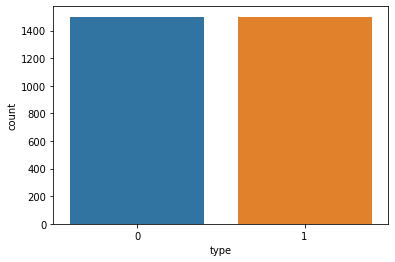

In [2]:
import seaborn as sns
sns.countplot(x='type', data=trump_data)

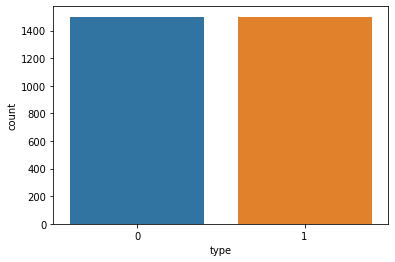

In [3]:
sns.countplot(x='type', data=obama_data)

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
class Metrics:
    def __init__(self, df):
        self.df = pd.read_pickle(df)
        self.union_speeches = []
        self.rally_speeches = []
        
    def find_avg_word_length(self):
        average_res = []
        rally = self._get_speeches_list_from_df(self.df,1)
        union = self._get_speeches_list_from_df(self.df,0)
        self.rally_speeches.append(rally)
        self.union_speeches.append(union)
        word_count = 0
        total_characters = 0
        for speech_list in [rally, union]:
            for speech in speech_list:
                word_count += len(speech.split())
                total_characters += len(speech) - speech.count(' ')
                
            avg_word_length = total_characters / word_count
            average_res.append(round(avg_word_length,2))
            
            
        return average_res


    def _get_speeches_list_from_df(self, df, attr_val):
        df_speeches = df.loc[df['type'] == attr_val]
        speeches_list = df_speeches['transcript'].tolist()

        return speeches_list

Using TensorFlow backend.


In [5]:
trump_snippits = Metrics("TRUMP_SNIPPETS_DF.pickle")
trump_speeches = Metrics('trump_speeches_df.pickle')
obama_speeches = Metrics('obama_speeches_df.pickle')
obama_snippits = Metrics('OBAMA_SNIPPETS_DF.pickle')


print(trump_snippits.find_avg_word_length(), trump_speeches.find_avg_word_length())
print(obama_snippits.find_avg_word_length(), obama_speeches.find_avg_word_length())

[5.57, 5.91] [4.25, 4.31]
[5.64, 5.91] [4.24, 4.33]


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
class Compress:
    def save_as_npz(self,df,npz_name=None,tran_data='transcript',label='type'):
        X = []
        y = np.array(df[label])
        sentences = np.array(df[tran_data])
        for sen in sentences:
            X.append(preprocess_text(sen))
                        
        self._train_test_split(np.array([X]).T, np.array(y), npz_filename=npz_name)
        
        

    def _train_test_split(self,X,y,npz_filename=''+'.npz',test_size=0.2, random_state=42):
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
        sss.get_n_splits(np.array(X), y)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        tokenizer = Tokenizer(num_words=30000)
        tokenizer.fit_on_texts(X_train.ravel())
        X_train = tokenizer.texts_to_sequences(X_train.ravel())
        X_test = tokenizer.texts_to_sequences(X_test.ravel())
        
        vocab_size = len(tokenizer.word_index) + 1

        maxlen = 100

        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
        
        embeddings_dictionary = dict()
        glove_file = open('glove.6B.50d.txt', encoding="utf8")

        for line in glove_file:
            records = line.split()
            word = records[0]
            vector_dimensions = asarray(records[1:], dtype='float32')
            embeddings_dictionary [word] = vector_dimensions
        glove_file.close()
        embedding_matrix = zeros((vocab_size, 50))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        
        np.savez_compressed(npz_filename,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        vocab_size=vocab_size, 
                        embedding_matrix=embedding_matrix)
        print("Saved {} as .npz".format(npz_filename))
    

In [8]:
compress = Compress()
compress.save_as_npz(trump_data, npz_name='TrumpSplitData')
compress.save_as_npz(obama_data, npz_name='ObamaSplitData')

(1500, 1) (1500,) (1500, 1) (1500,)
Saved TrumpSplitData as .npz
(1500, 1) (1500,) (1500, 1) (1500,)
Saved ObamaSplitData as .npz


In [9]:
import numpy as np
class load_file:
    def __init__(self, file):
        self.file = file

    def get_data(self):
        hal = np.load(self.file)
        X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = [hal[f] for f in hal.files]
        return X_train, y_train, X_test, y_test,vocab_size, embedding_matrix


df = load_file('TrumpSplitData.npz')
X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = df.get_data()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 50)           163250    
_________________________________________________________________
dense_88 (Dense)             (None, 100, 32)           1632      
_________________________________________________________________
dropout_72 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
dense_89 (Dense)             (None, 100, 64)           2112      
_________________________________________________________________
dropout_73 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
dense_90 (Dense)             (None, 100, 128)          8320      
_________________________________________________________________
dropout_74 (Dropout)         (None, 100, 128)        

/home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 1500 samples
Epoch 1/500
1500/1500 [==============================] - 1s 374us/step - loss: 8.7473 - acc: 0.5293 - val_loss: 8.0649 - val_acc: 0.5473
Epoch 2/500
1500/1500 [==============================] - 0s 185us/step - loss: 8.6894 - acc: 0.5167 - val_loss: 8.0161 - val_acc: 0.5540
Epoch 3/500
1500/1500 [==============================] - 0s 176us/step - loss: 8.6386 - acc: 0.5160 - val_loss: 7.9679 - val_acc: 0.5613
Epoch 4/500
1500/1500 [==============================] - 0s 176us/step - loss: 8.5853 - acc: 0.5467 - val_loss: 7.9201 - val_acc: 0.5747
Epoch 5/500
1500/1500 [==============================] - 0s 172us/step - loss: 8.5305 - acc: 0.5513 - val_loss: 7.8729 - val_acc: 0.5733
Epoch 6/500
1500/1500 [==============================] - 0s 177us/step - loss: 8.4855 - acc: 0.5527 - val_loss: 7.8261 - val_acc: 0.5727
Epoch 7/500
1500/1500 [==============================] - 0s 170us/step - loss: 8.4334 - acc: 0.5380 - val_loss: 7.7799 - val_acc: 

1500/1500 [==============================] - 0s 173us/step - loss: 6.2089 - acc: 0.6667 - val_loss: 5.7074 - val_acc: 0.6893
Epoch 61/500
1500/1500 [==============================] - 0s 172us/step - loss: 6.1688 - acc: 0.6680 - val_loss: 5.6739 - val_acc: 0.6933
Epoch 62/500
1500/1500 [==============================] - 0s 176us/step - loss: 6.1465 - acc: 0.6580 - val_loss: 5.6414 - val_acc: 0.6933
Epoch 63/500
1500/1500 [==============================] - 0s 170us/step - loss: 6.1082 - acc: 0.6560 - val_loss: 5.6090 - val_acc: 0.6940
Epoch 64/500
1500/1500 [==============================] - 0s 173us/step - loss: 6.0700 - acc: 0.6513 - val_loss: 5.5761 - val_acc: 0.6960
Epoch 65/500
1500/1500 [==============================] - 0s 169us/step - loss: 6.0400 - acc: 0.6487 - val_loss: 5.5440 - val_acc: 0.6960
Epoch 66/500
1500/1500 [==============================] - 0s 173us/step - loss: 5.9968 - acc: 0.6613 - val_loss: 5.5127 - val_acc: 0.6900
Epoch 67/500
1500/1500 [=======================

1500/1500 [==============================] - 0s 172us/step - loss: 4.4406 - acc: 0.6920 - val_loss: 4.0616 - val_acc: 0.7287
Epoch 120/500
1500/1500 [==============================] - 0s 170us/step - loss: 4.4205 - acc: 0.6893 - val_loss: 4.0404 - val_acc: 0.7293
Epoch 121/500
1500/1500 [==============================] - 0s 173us/step - loss: 4.4023 - acc: 0.6953 - val_loss: 4.0172 - val_acc: 0.7300
Epoch 122/500
1500/1500 [==============================] - 0s 176us/step - loss: 4.3584 - acc: 0.6967 - val_loss: 3.9942 - val_acc: 0.7300
Epoch 123/500
1500/1500 [==============================] - 0s 169us/step - loss: 4.3518 - acc: 0.6833 - val_loss: 3.9700 - val_acc: 0.7293
Epoch 124/500
1500/1500 [==============================] - 0s 179us/step - loss: 4.3253 - acc: 0.6913 - val_loss: 3.9475 - val_acc: 0.7300
Epoch 125/500
1500/1500 [==============================] - 0s 170us/step - loss: 4.2889 - acc: 0.7113 - val_loss: 3.9267 - val_acc: 0.7327
Epoch 126/500
1500/1500 [================

1500/1500 [==============================] - 0s 169us/step - loss: 3.2039 - acc: 0.6980 - val_loss: 2.9067 - val_acc: 0.7407
Epoch 179/500
1500/1500 [==============================] - 0s 169us/step - loss: 3.1693 - acc: 0.7047 - val_loss: 2.8875 - val_acc: 0.7407
Epoch 180/500
1500/1500 [==============================] - 0s 166us/step - loss: 3.1549 - acc: 0.7207 - val_loss: 2.8729 - val_acc: 0.7427
Epoch 181/500
1500/1500 [==============================] - 0s 170us/step - loss: 3.1444 - acc: 0.7213 - val_loss: 2.8557 - val_acc: 0.7413
Epoch 182/500
1500/1500 [==============================] - 0s 168us/step - loss: 3.1245 - acc: 0.7087 - val_loss: 2.8420 - val_acc: 0.7413
Epoch 183/500
1500/1500 [==============================] - 0s 169us/step - loss: 3.1083 - acc: 0.6993 - val_loss: 2.8230 - val_acc: 0.7407
Epoch 184/500
1500/1500 [==============================] - 0s 172us/step - loss: 3.0722 - acc: 0.7247 - val_loss: 2.8056 - val_acc: 0.7460
Epoch 185/500
1500/1500 [================

1500/1500 [==============================] - 0s 171us/step - loss: 2.3230 - acc: 0.7300 - val_loss: 2.0954 - val_acc: 0.7553
Epoch 238/500
1500/1500 [==============================] - 0s 173us/step - loss: 2.3010 - acc: 0.7200 - val_loss: 2.0849 - val_acc: 0.7560
Epoch 239/500
1500/1500 [==============================] - 0s 170us/step - loss: 2.2867 - acc: 0.7300 - val_loss: 2.0727 - val_acc: 0.7560
Epoch 240/500
1500/1500 [==============================] - 0s 175us/step - loss: 2.2935 - acc: 0.7180 - val_loss: 2.0620 - val_acc: 0.7560
Epoch 241/500
1500/1500 [==============================] - 0s 175us/step - loss: 2.2626 - acc: 0.7267 - val_loss: 2.0527 - val_acc: 0.7553
Epoch 242/500
1500/1500 [==============================] - 0s 172us/step - loss: 2.2540 - acc: 0.7433 - val_loss: 2.0387 - val_acc: 0.7560
Epoch 243/500
1500/1500 [==============================] - 0s 179us/step - loss: 2.2577 - acc: 0.7180 - val_loss: 2.0324 - val_acc: 0.7547
Epoch 244/500
1500/1500 [================

1500/1500 [==============================] - 0s 163us/step - loss: 1.7333 - acc: 0.7287 - val_loss: 1.5554 - val_acc: 0.7647
Epoch 297/500
1500/1500 [==============================] - 0s 169us/step - loss: 1.7227 - acc: 0.7367 - val_loss: 1.5486 - val_acc: 0.7640
Epoch 298/500
1500/1500 [==============================] - 0s 170us/step - loss: 1.6941 - acc: 0.7353 - val_loss: 1.5400 - val_acc: 0.7633
Epoch 299/500
1500/1500 [==============================] - 0s 169us/step - loss: 1.6984 - acc: 0.7247 - val_loss: 1.5327 - val_acc: 0.7647
Epoch 300/500
1500/1500 [==============================] - 0s 169us/step - loss: 1.6827 - acc: 0.7520 - val_loss: 1.5266 - val_acc: 0.7633
Epoch 301/500
1500/1500 [==============================] - 0s 171us/step - loss: 1.6896 - acc: 0.7380 - val_loss: 1.5189 - val_acc: 0.7633
Epoch 302/500
1500/1500 [==============================] - 0s 172us/step - loss: 1.6628 - acc: 0.7440 - val_loss: 1.5121 - val_acc: 0.7633
Epoch 303/500
1500/1500 [================

1500/1500 [==============================] - 0s 168us/step - loss: 1.3136 - acc: 0.7733 - val_loss: 1.2004 - val_acc: 0.7640
Epoch 356/500
1500/1500 [==============================] - 0s 172us/step - loss: 1.3144 - acc: 0.7573 - val_loss: 1.1956 - val_acc: 0.7653
Epoch 357/500
1500/1500 [==============================] - 0s 167us/step - loss: 1.3218 - acc: 0.7453 - val_loss: 1.1911 - val_acc: 0.7667
Epoch 358/500
1500/1500 [==============================] - 0s 178us/step - loss: 1.2859 - acc: 0.7673 - val_loss: 1.1858 - val_acc: 0.7640
Epoch 359/500
1500/1500 [==============================] - 0s 172us/step - loss: 1.2917 - acc: 0.7793 - val_loss: 1.1819 - val_acc: 0.7687
Epoch 360/500
1500/1500 [==============================] - 0s 169us/step - loss: 1.2807 - acc: 0.7593 - val_loss: 1.1768 - val_acc: 0.7680
Epoch 361/500
1500/1500 [==============================] - 0s 173us/step - loss: 1.2834 - acc: 0.7693 - val_loss: 1.1721 - val_acc: 0.7687
Epoch 362/500
1500/1500 [================

1500/1500 [==============================] - 0s 170us/step - loss: 1.0424 - acc: 0.7893 - val_loss: 0.9666 - val_acc: 0.7800
Epoch 415/500
1500/1500 [==============================] - 0s 171us/step - loss: 1.0514 - acc: 0.7807 - val_loss: 0.9633 - val_acc: 0.7807
Epoch 416/500
1500/1500 [==============================] - 0s 172us/step - loss: 1.0486 - acc: 0.7807 - val_loss: 0.9606 - val_acc: 0.7800
Epoch 417/500
1500/1500 [==============================] - 0s 173us/step - loss: 1.0459 - acc: 0.7740 - val_loss: 0.9579 - val_acc: 0.7780
Epoch 418/500
1500/1500 [==============================] - 0s 170us/step - loss: 1.0437 - acc: 0.7660 - val_loss: 0.9540 - val_acc: 0.7800
Epoch 419/500
1500/1500 [==============================] - 0s 172us/step - loss: 1.0219 - acc: 0.7887 - val_loss: 0.9508 - val_acc: 0.7807
Epoch 420/500
1500/1500 [==============================] - 0s 171us/step - loss: 1.0227 - acc: 0.7987 - val_loss: 0.9479 - val_acc: 0.7807
Epoch 421/500
1500/1500 [================

1500/1500 [==============================] - 0s 173us/step - loss: 0.8834 - acc: 0.7940 - val_loss: 0.8140 - val_acc: 0.7920
Epoch 474/500
1500/1500 [==============================] - 0s 173us/step - loss: 0.8686 - acc: 0.8027 - val_loss: 0.8114 - val_acc: 0.7953
Epoch 475/500
1500/1500 [==============================] - 0s 175us/step - loss: 0.8629 - acc: 0.7933 - val_loss: 0.8093 - val_acc: 0.7960
Epoch 476/500
1500/1500 [==============================] - 0s 170us/step - loss: 0.8623 - acc: 0.7927 - val_loss: 0.8077 - val_acc: 0.7947
Epoch 477/500
1500/1500 [==============================] - 0s 169us/step - loss: 0.8541 - acc: 0.8113 - val_loss: 0.8054 - val_acc: 0.7940
Epoch 478/500
1500/1500 [==============================] - 0s 173us/step - loss: 0.8803 - acc: 0.7780 - val_loss: 0.8032 - val_acc: 0.7940
Epoch 479/500
1500/1500 [==============================] - 0s 174us/step - loss: 0.8671 - acc: 0.7860 - val_loss: 0.8028 - val_acc: 0.7973
Epoch 480/500
1500/1500 [================

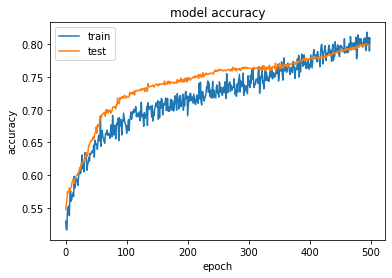

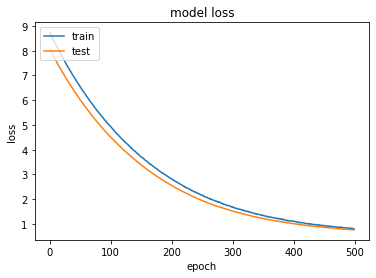

1500/1500 [==============================] - 0s 65us/step
Training Accuracy is 86.79999709129333
1500/1500 [==============================] - 0s 68us/step
Testing Accuracy is 79.93333339691162 
Accuracy: 0.799333
Precision: 0.818440
Recall: 0.769333
F1 score: 0.793127
[[622 128]
 [173 577]]


In [31]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.constraints import max_norm
from keras.regularizers import l1,l2
from keras import optimizers
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
maxlen = 100
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen)
model.add(embedding_layer)
keras.layers.BatchNormalization()

model.add(Dense(32, activity_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.4))
keras.layers.BatchNormalization()

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
keras.layers.BatchNormalization()


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
keras.layers.BatchNormalization()
keras.layers.BatchNormalization()




model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=.00001), loss='binary_crossentropy', metrics=['acc'])
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print(model.summary())
history = model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_test, y_test))


import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

loss, accuracy = model.evaluate(X_test,y_test)


print('Testing Accuracy is {} '.format(accuracy*100))


yhat_classes = model.predict_classes(X_test)


accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

In [11]:
model.save("TrumpModel.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[598 152]
 [ 75 675]]


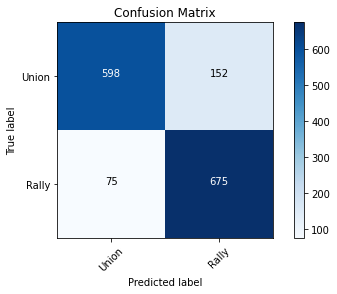

In [23]:
cm =confusion_matrix(y_test, yhat_classes)
labels = [ 'Union','Rally']
plot_confusion_matrix(cm, labels, title='Confusion Matrix')